In [30]:
import pandas as pd
import numpy as np

In [49]:
closing_price = pd.read_csv('assets\Closing_price_upto_2022.csv')
prices = closing_price.set_index('Ticker').transpose()
prices.index = pd.to_datetime(prices.index)

In [50]:
combined_df = pd.read_csv('assets/combined_features.csv')
combined_df['Ticker']=combined_df['Unnamed: 0']
combined_df=combined_df.drop(columns='Unnamed: 0')

In [51]:
prices = prices.dropna(axis=1)
combined_df = combined_df.dropna()
print(prices.shape)
print(combined_df.shape)

(2704, 1119)
(606, 16)


In [57]:
ticker_list = combined_df['Ticker'].tolist()
print(ticker_list)
columns_to_keep =  [col for col in prices.columns if col in ticker_list]
prices = prices[columns_to_keep]


['20MICRONS.BO', '21STCENMGM.BO', '3MINDIA.BO', 'AARTIDRUGS.BO', 'AARTIIND.BO', 'ABBOTINDIA.BO', 'ACC.BO', 'ACCELYA.BO', 'ACE.BO', 'ADANIENT.BO', 'ADANIPORTS.BO', 'ADFFOODS.BO', 'ADORWELD.BO', 'ADSL.BO', 'ADVANIHOTR.BO', 'AEGISLOG.BO', 'AGARIND.BO', 'AHLEAST.BO', 'AHLUCONT.BO', 'AIAENG.BO', 'AJANTPHARM.BO', 'AJMERA.BO', 'AKZOINDIA.BO', 'ALEMBICLTD.BO', 'ALICON.BO', 'ALKYLAMINE.BO', 'ALPHAGEO.BO', 'AMBIKCO.BO', 'AMBUJACEM.BO', 'AMRUTANJAN.BO', 'ANANTRAJ.BO', 'ANDHRSUGAR.BO', 'APARINDS.BO', 'APCOTEXIND.BO', 'APLAPOLLO.BO', 'APLLTD.BO', 'APOLLOHOSP.BO', 'APOLLOTYRE.BO', 'APTECHT.BO', 'ARIES.BO', 'ARROWGREEN.BO', 'ARVIND.BO', 'ASAHIINDIA.BO', 'ASAHISONG.BO', 'ASHIANA.BO', 'ASHOKLEY.BO', 'ASIANPAINT.BO', 'ASTRAMICRO.BO', 'ASTRAZEN.BO', 'ATFL.BO', 'ATUL.BO', 'AURIONPRO.BO', 'AUROPHARMA.BO', 'AUTOAXLES.BO', 'AUTOINT.BO', 'AVTNPL.BO', 'AXISBANK.BO', 'BAJAJ-AUTO.BO', 'BAJAJELEC.BO', 'BAJAJFINSV.BO', 'BAJAJHLDNG.BO', 'BALAMINES.BO', 'BALKRISIND.BO', 'BALMLAWRIE.BO', 'BALPHARMA.BO', 'BALRAMCHIN.B

In [58]:
def remove_flat_stocks_and_filter_spreads(prices, combined_df, lookback=60, threshold=1e-5,
                                          min_crossings=3, min_days_year=200):

    flat_remove = []
    for col in prices.columns:
        series = prices[col].dropna()
        if len(series) < lookback or series.iloc[-lookback:].std() < threshold:
            flat_remove.append(col)

    filtered_prices = prices.drop(columns=flat_remove)
    combined_df = combined_df[~combined_df["Ticker"].isin(flat_remove)]

    spread_remove = []
    for col in filtered_prices.columns:
        series = filtered_prices[col].dropna()
        if not isinstance(series.index, pd.DatetimeIndex):
            series.index = pd.to_datetime(series.index, errors='coerce')
            if series.index.isna().any():
                spread_remove.append(col)
                continue

        meets_criteria = True
        groups = series.groupby(series.index.year)
        for year, data in groups:
            if len(data) >= min_days_year:
                spread = data - data.mean()
                crossings = np.where(np.diff(np.sign(spread)))[0].size
                if crossings < min_crossings:
                    meets_criteria = False
                    break

        if not meets_criteria:
            spread_remove.append(col)

    filtered_prices = filtered_prices.drop(columns=spread_remove)
    combined_df = combined_df[~combined_df["Ticker"].isin(spread_remove)]

    return filtered_prices, combined_df

prices, combined_df = remove_flat_stocks_and_filter_spreads(prices, combined_df, lookback=60, threshold=1e-5)

print(prices.shape)
print(combined_df.shape)


(2704, 171)
(171, 16)


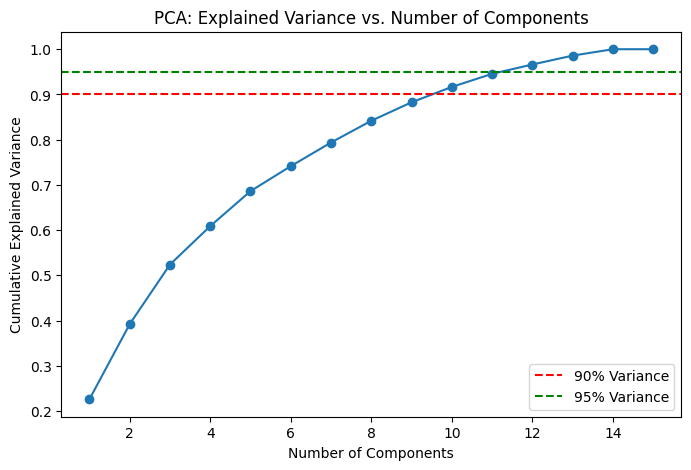

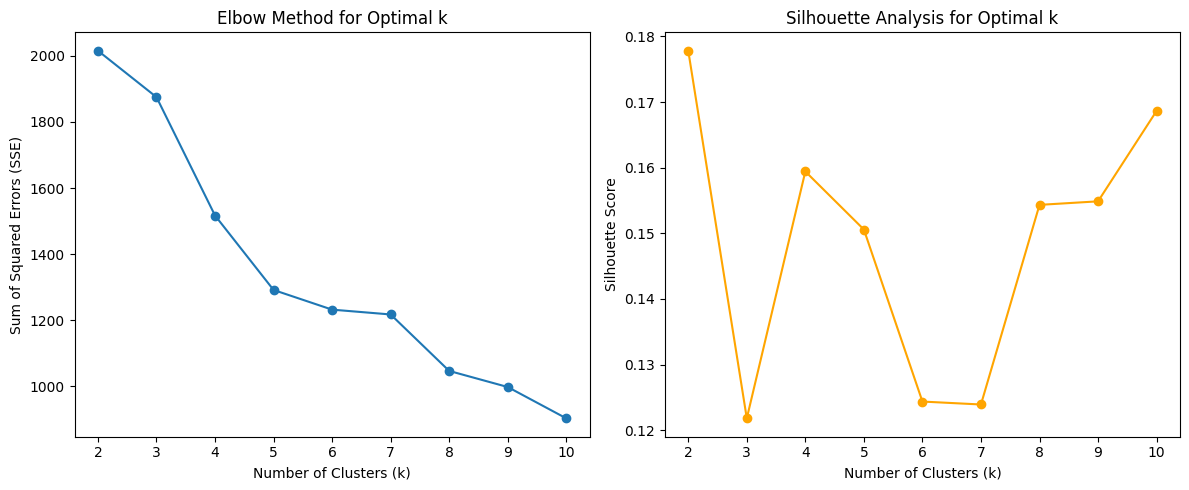

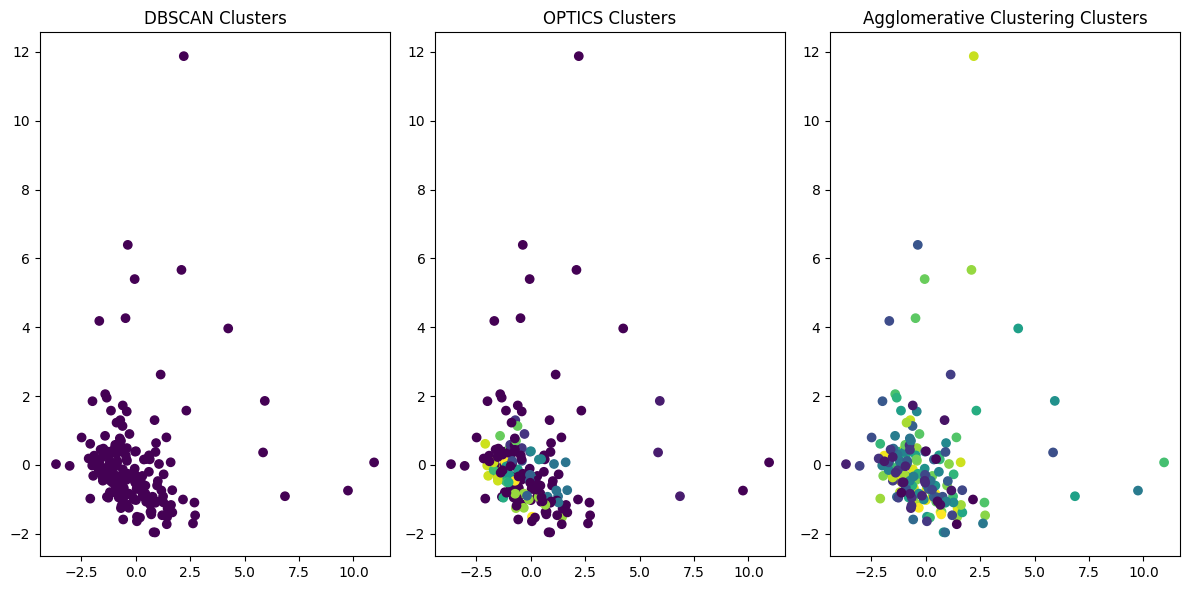

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn.metrics import silhouette_score

scaler = StandardScaler()

Ticker = combined_df['Ticker']
combined_df = combined_df.drop(columns='Ticker')
scaled_combined = scaler.fit_transform(combined_df)

pca_full = PCA(n_components=scaled_combined.shape[1])
pca_full.fit(scaled_combined)
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs. Number of Components')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Variance')
plt.legend()
plt.show()

pca = PCA(n_components=10)
combined_features_pca = pca.fit_transform(scaled_combined)

sse = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_features_pca)
    sse.append(kmeans.inertia_)
    score = silhouette_score(combined_features_pca, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.tight_layout()
plt.show()

dbscan = DBSCAN(eps=0.5, min_samples=3)
optics = OPTICS(min_samples=3)
agglomerative = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5)

combined_dbscan_labels = dbscan.fit_predict(combined_features_pca)
combined_optics_labels = optics.fit_predict(combined_features_pca)
combined_agglomerative_labels = agglomerative.fit_predict(combined_features_pca)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(combined_features_pca[:, 0], combined_features_pca[:, 1],
            c=combined_dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clusters')

plt.subplot(1, 3, 2)
plt.scatter(combined_features_pca[:, 0], combined_features_pca[:, 1],
            c=combined_optics_labels, cmap='viridis')
plt.title('OPTICS Clusters')

plt.subplot(1, 3, 3)
plt.scatter(combined_features_pca[:, 0], combined_features_pca[:, 1],
            c=combined_agglomerative_labels, cmap='viridis')
plt.title('Agglomerative Clustering Clusters')

plt.tight_layout()
plt.show()


In [60]:
print("Number of clusters in DBSCAN:", len(set(combined_dbscan_labels)) - (1 if -1 in combined_dbscan_labels else 0))
print("Number of clusters in OPTICS:", len(set(combined_optics_labels)) - (1 if -1 in combined_optics_labels else 0))
print("Number of clusters in Agglomerative Clustering:", len(set(combined_agglomerative_labels)) - (1 if -1 in combined_agglomerative_labels else 0))

Number of clusters in DBSCAN: 0
Number of clusters in OPTICS: 13
Number of clusters in Agglomerative Clustering: 171


Text(0.5, 1.0, 'Agglomerative Clustering Clusters')

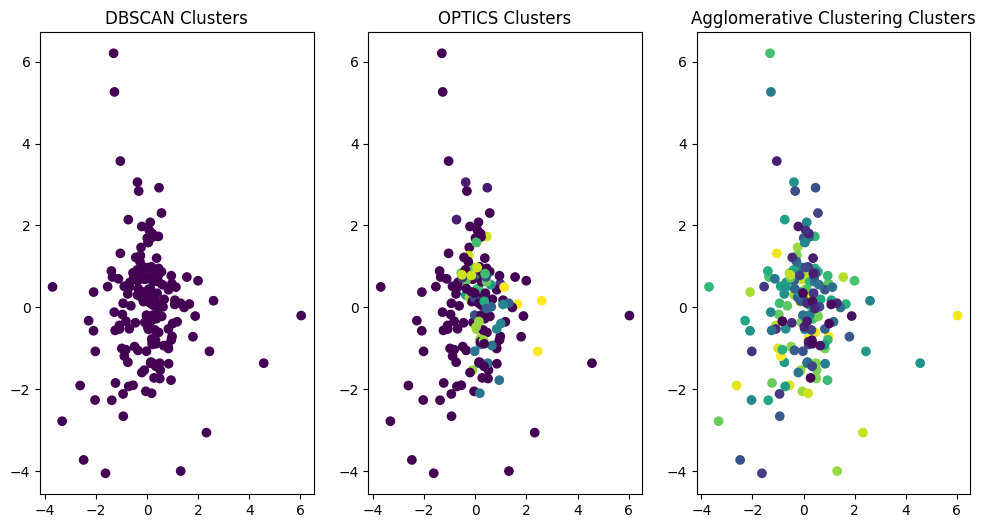

In [61]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.scatter(combined_features_pca[:, 3], combined_features_pca[:, 2], c=combined_dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clusters')

plt.subplot(1, 3, 2)
plt.scatter(combined_features_pca[:, 3], combined_features_pca[:, 2], c=combined_optics_labels, cmap='viridis')
plt.title('OPTICS Clusters')

plt.subplot(1, 3, 3)
plt.scatter(combined_features_pca[:, 3], combined_features_pca[:, 2], c=combined_agglomerative_labels, cmap='viridis')
plt.title('Agglomerative Clustering Clusters')


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint

def compute_hurst(ts):
    """
    Compute the Hurst exponent of the time series 'ts' using the rescaled range method.
    Returns NaN if not enough data points are available.
    """
    if len(ts) < 20:
        return np.nan
    max_lag = min(100, len(ts) // 2)
    lags = range(2, max_lag)

    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    if any(t <= 0 for t in tau):
        return np.nan
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    hurst = poly[0]
    return hurst

In [72]:
from scipy.stats import zscore
prices = prices.apply(zscore)

Processing Cluster 0 with tickers: ['3MINDIA.BO', 'BOSCHLTD.BO', 'SHREECEM.BO']
Processing Cluster 1 with tickers: ['APOLLOTYRE.BO', 'BHARATFORG.BO', 'CHAMBLFERT.BO', 'MUNJALAU.BO']
Processing Cluster 2 with tickers: ['BALRAMCHIN.BO', 'NCLIND.BO', 'SUNTV.BO', 'SUPERHOUSE.BO']
Processing Cluster 3 with tickers: ['SUBROS.BO', 'SUNDRMBRAK.BO', 'TI.BO']
Processing Cluster 4 with tickers: ['BLUESTARCO.BO', 'DRREDDY.BO', 'GRINDWELL.BO', 'LUPIN.BO', 'NESCO.BO', 'SUNDARMFIN.BO', 'THERMAX.BO']
Processing Cluster 5 with tickers: ['EXIDEIND.BO', 'UNITDSPR.BO', 'VOLTAS.BO']
Processing Cluster 6 with tickers: ['EXCELINDUS.BO', 'JAYAGROGN.BO', 'MANALIPETC.BO', 'POLYPLEX.BO']
Processing Cluster 7 with tickers: ['BANSWRAS.BO', 'RESPONIND.BO', 'THOMASCOOK.BO']
Processing Cluster 8 with tickers: ['JINDRILL.BO', 'ROHLTD.BO', 'TAJGVK.BO']
Processing Cluster 9 with tickers: ['CANFINHOME.BO', 'EDELWEISS.BO', 'LICHSGFIN.BO', 'PEL.BO']
Processing Cluster 10 with tickers: ['AIAENG.BO', 'ELGIEQUIP.BO', 'HONDAPO

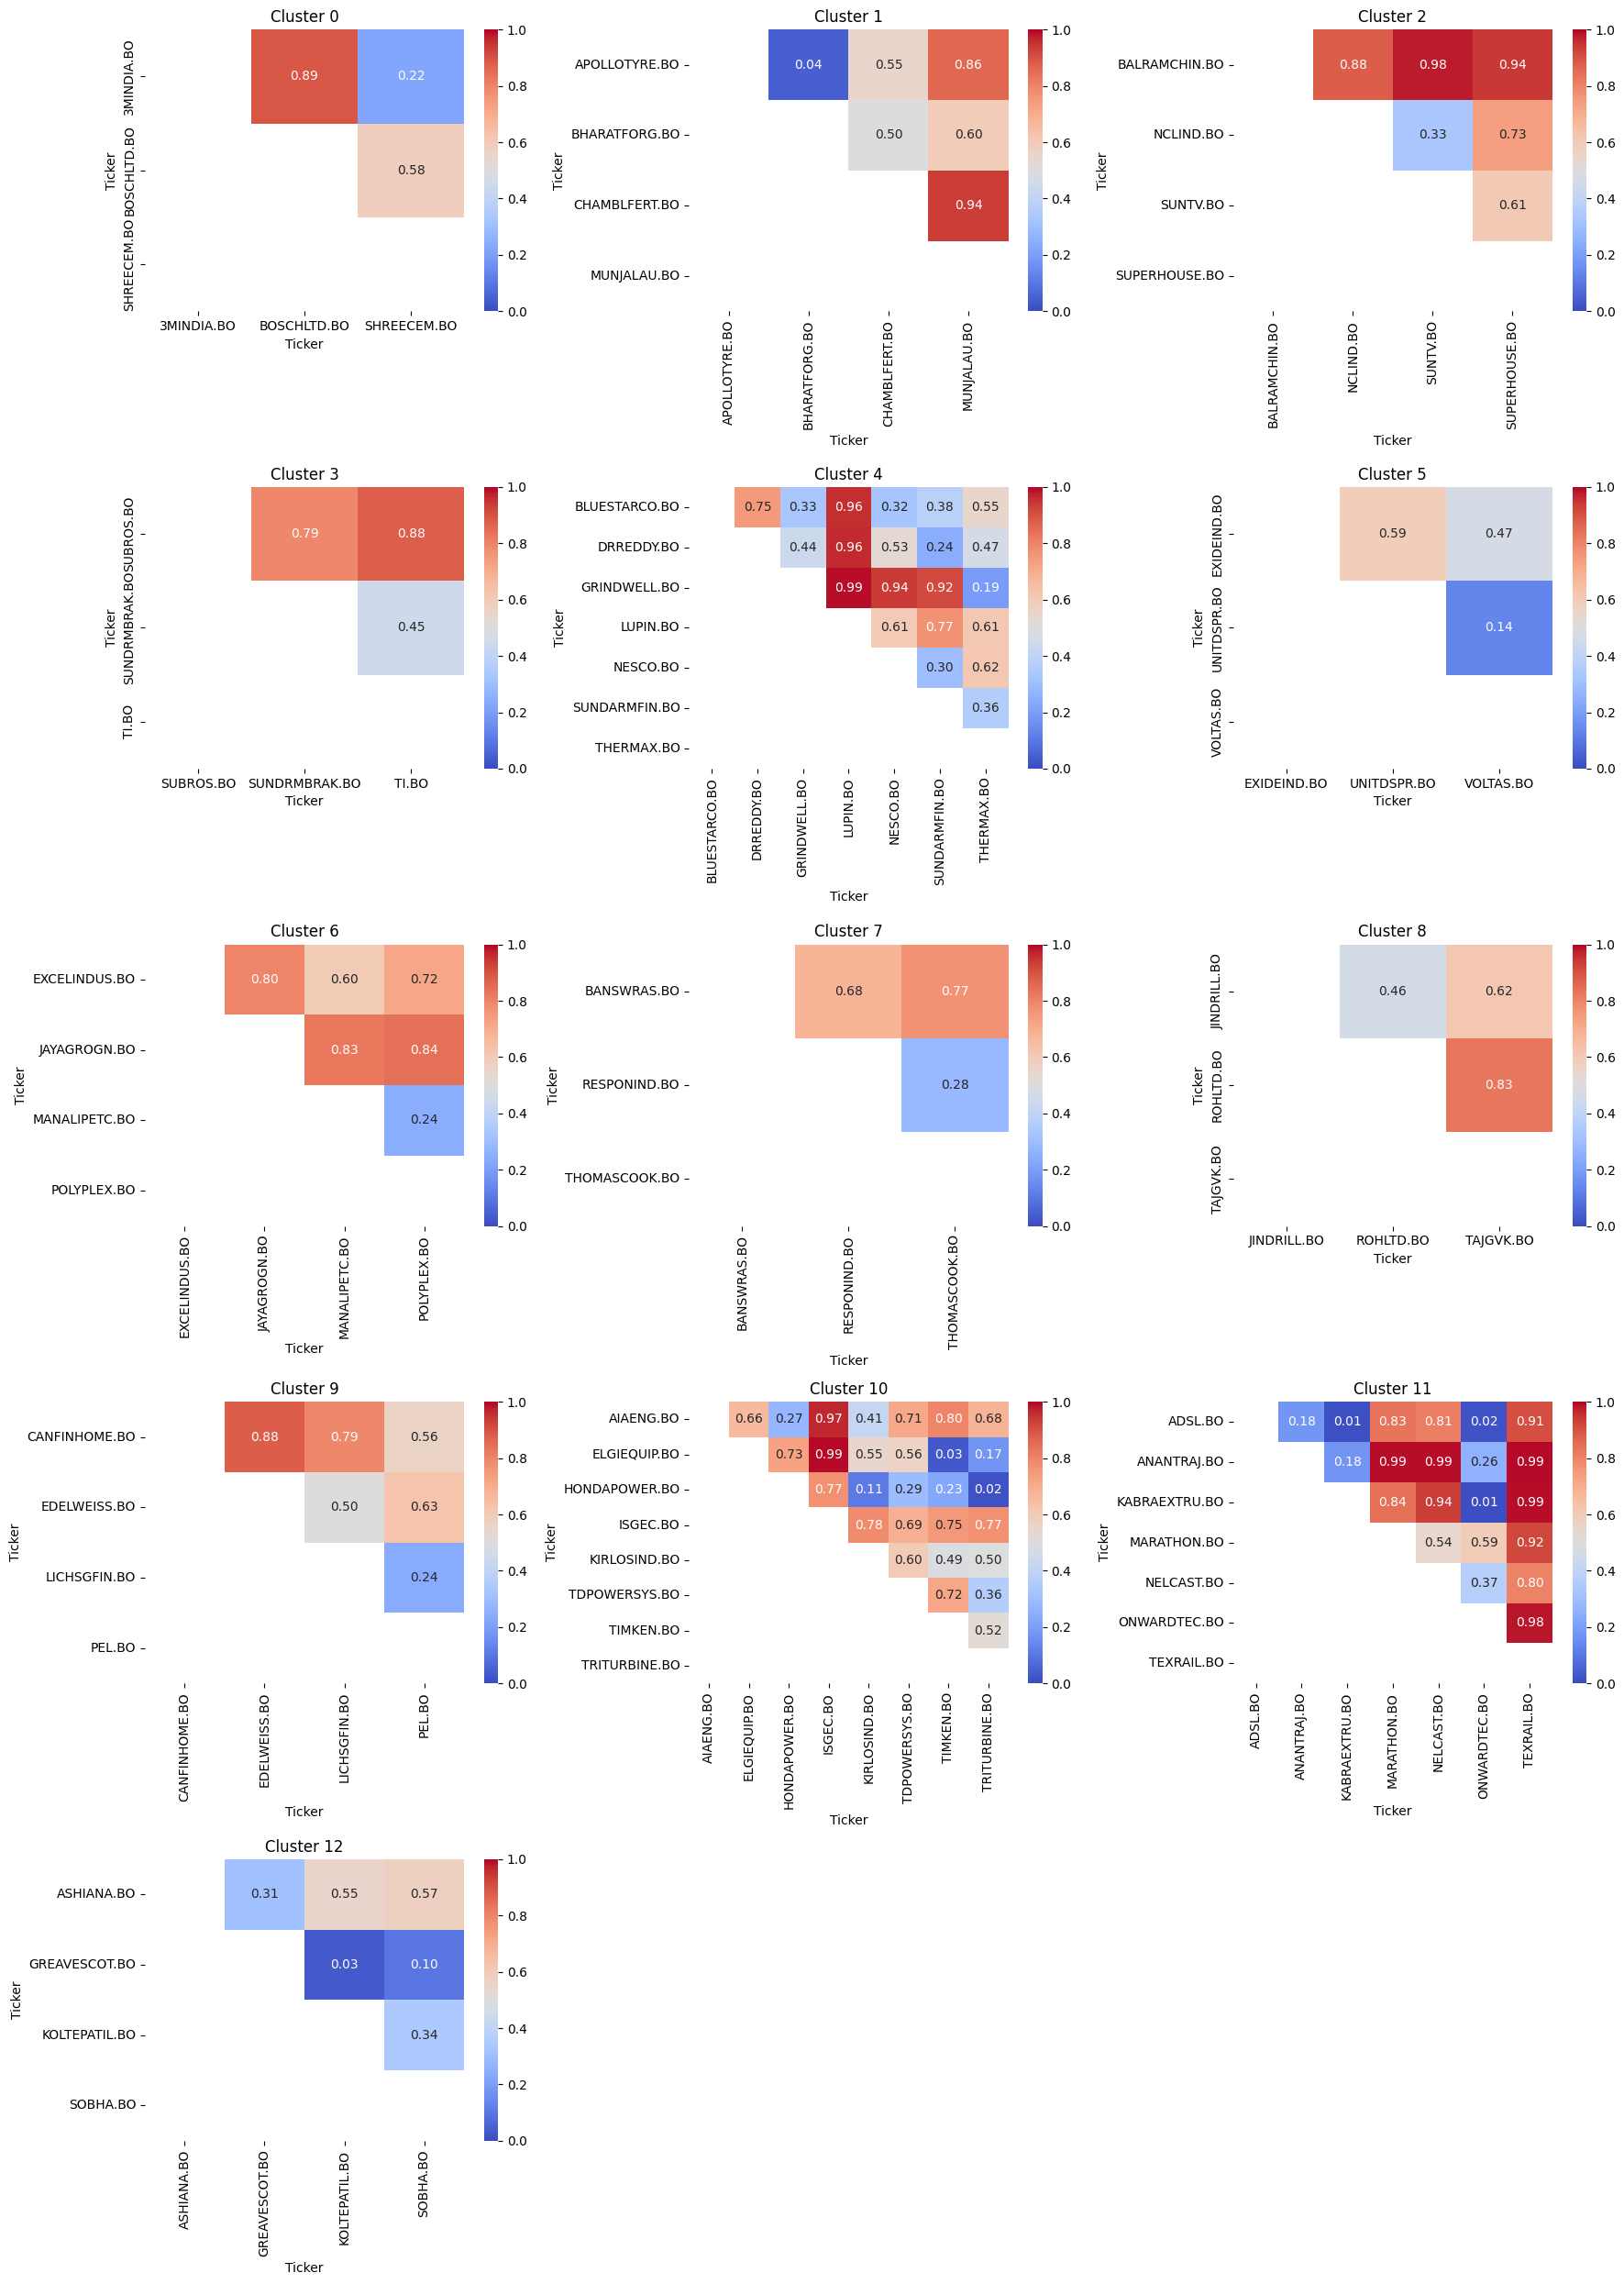

In [73]:
labels_list = np.array(combined_optics_labels)
tickers = prices.columns.tolist()
if len(labels_list) != len(tickers):
    raise ValueError("The number of cluster labels does not match the number of tickers in the prices DataFrame.")
cluster_labels = pd.Series(labels_list, index=tickers)

unique_clusters = sorted([cl for cl in cluster_labels.unique() if cl != -1])
n_clusters = len(unique_clusters)
ncols = 3
nrows = int(np.ceil(n_clusters / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 5))
axes = axes.flatten()

coint_results = []

for idx, cluster in enumerate(unique_clusters):
    tickers_in_cluster = cluster_labels[cluster_labels == cluster].index.tolist()
    print(f"Processing Cluster {cluster} with tickers: {tickers_in_cluster}")

    coint_matrix = pd.DataFrame(index=tickers_in_cluster, columns=tickers_in_cluster, dtype=float)

    for i, ticker1 in enumerate(tickers_in_cluster):
        for j, ticker2 in enumerate(tickers_in_cluster):
            if i >= j:
                coint_matrix.loc[ticker1, ticker2] = np.nan
                continue
            series1 = prices[ticker1].dropna()
            series2 = prices[ticker2].dropna()
            common_dates = series1.index.intersection(series2.index)
            if len(common_dates) > 0:
                series1_aligned = series1.loc[common_dates]
                series2_aligned = series2.loc[common_dates]
                try:
                    score, pvalue, _ = coint(series1_aligned, series2_aligned)
                except Exception as e:
                    print(f"Error testing cointegration between {ticker1} and {ticker2}: {e}")
                    pvalue = np.nan

                coint_matrix.loc[ticker1, ticker2] = pvalue
                coint_matrix.loc[ticker2, ticker1] = pvalue

                try:
                    beta, alpha = np.polyfit(series2_aligned, series1_aligned, 1)

                    spread = series1_aligned - (beta * series2_aligned + alpha)
                    hurst = compute_hurst(spread.values)
                except Exception as e:
                    print(f"Error computing hedge/Hurst for {ticker1} and {ticker2}: {e}")
                    beta, alpha, hurst = np.nan, np.nan, np.nan
                coint_results.append({
                    'cluster': cluster,
                    'ticker1': ticker1,
                    'ticker2': ticker2,
                    'pvalue': pvalue,
                    'hurst': hurst,
                    'beta': beta,
                    'alpha': alpha
                })
            else:
                coint_matrix.loc[ticker1, ticker2] = np.nan
                coint_matrix.loc[ticker2, ticker1] = np.nan
    ax = axes[idx]
    sns.heatmap(coint_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, ax=ax)
    ax.set_title(f"Cluster {cluster}")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("Ticker")

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [74]:
coint_results_df = pd.DataFrame(coint_results)
coint_results_df.to_csv("assets/cointegration_hurst_results.csv", index=False)

In [75]:
filtered_pairs = coint_results_df.dropna(subset=['pvalue', 'hurst'])
# filtered_pairs = filtered_pairs[~filtered_pairs['ticker1'].isin(['KSERASERA.BO', 'ICSA.BO', 'RUIAAQA.BO', 'NUTEK.BO', 'PUNJLLOYD.BO', 'KGL.BO','SATHAISPAT.BO', 'INDOSOLAR.BO', 'SIYSIL.BO', 'UNIPLY.BO', 'SPECMKT.BO', 'IVRCLINFRA.BO'])]
# filtered_pairs = filtered_pairs[~filtered_pairs['ticker2'].isin(['KSERASERA.BO', 'ICSA.BO', 'RUIAAQA.BO', 'NUTEK.BO', 'PUNJLLOYD.BO', 'KGL.BO', 'SATHAISPAT.BO', 'INDOSOLAR.BO', 'SIYSIL.BO' ,'UNIPLY.BO', 'SPECMKT.BO', 'IVRCLINFRA.BO'])]

mean_reverting_pairs = filtered_pairs[(filtered_pairs['pvalue'] < 0.5) & (filtered_pairs['hurst'] < 0.5)]
top_pairs = mean_reverting_pairs.sort_values(by='pvalue').head(20)

print("Top 20 pairs based on cointegration and Hurst exponent criteria:")
print(top_pairs)

Top 20 pairs based on cointegration and Hurst exponent criteria:
     cluster        ticker1        ticker2    pvalue     hurst      beta  \
101       11  KABRAEXTRU.BO   ONWARDTEC.BO  0.007135  0.365099  0.966505   
89        11        ADSL.BO  KABRAEXTRU.BO  0.008820  0.406930  0.929473   
77        10  HONDAPOWER.BO  TRITURBINE.BO  0.015340  0.371268  0.856658   
92        11        ADSL.BO   ONWARDTEC.BO  0.018270  0.370806  0.936986   
71        10   ELGIEQUIP.BO      TIMKEN.BO  0.029961  0.250632  0.965686   
112       12  GREAVESCOT.BO  KOLTEPATIL.BO  0.032359  0.457532  0.748406   
3          1  APOLLOTYRE.BO  BHARATFORG.BO  0.043509  0.462171  0.905508   
113       12  GREAVESCOT.BO       SOBHA.BO  0.096502  0.423492  0.670025   
74        10  HONDAPOWER.BO   KIRLOSIND.BO  0.107319  0.416454  0.788511   
41         5    UNITDSPR.BO      VOLTAS.BO  0.136284  0.433057  0.718400   
72        10   ELGIEQUIP.BO  TRITURBINE.BO  0.172400  0.367902  0.862081   
94        11    ANANTRA

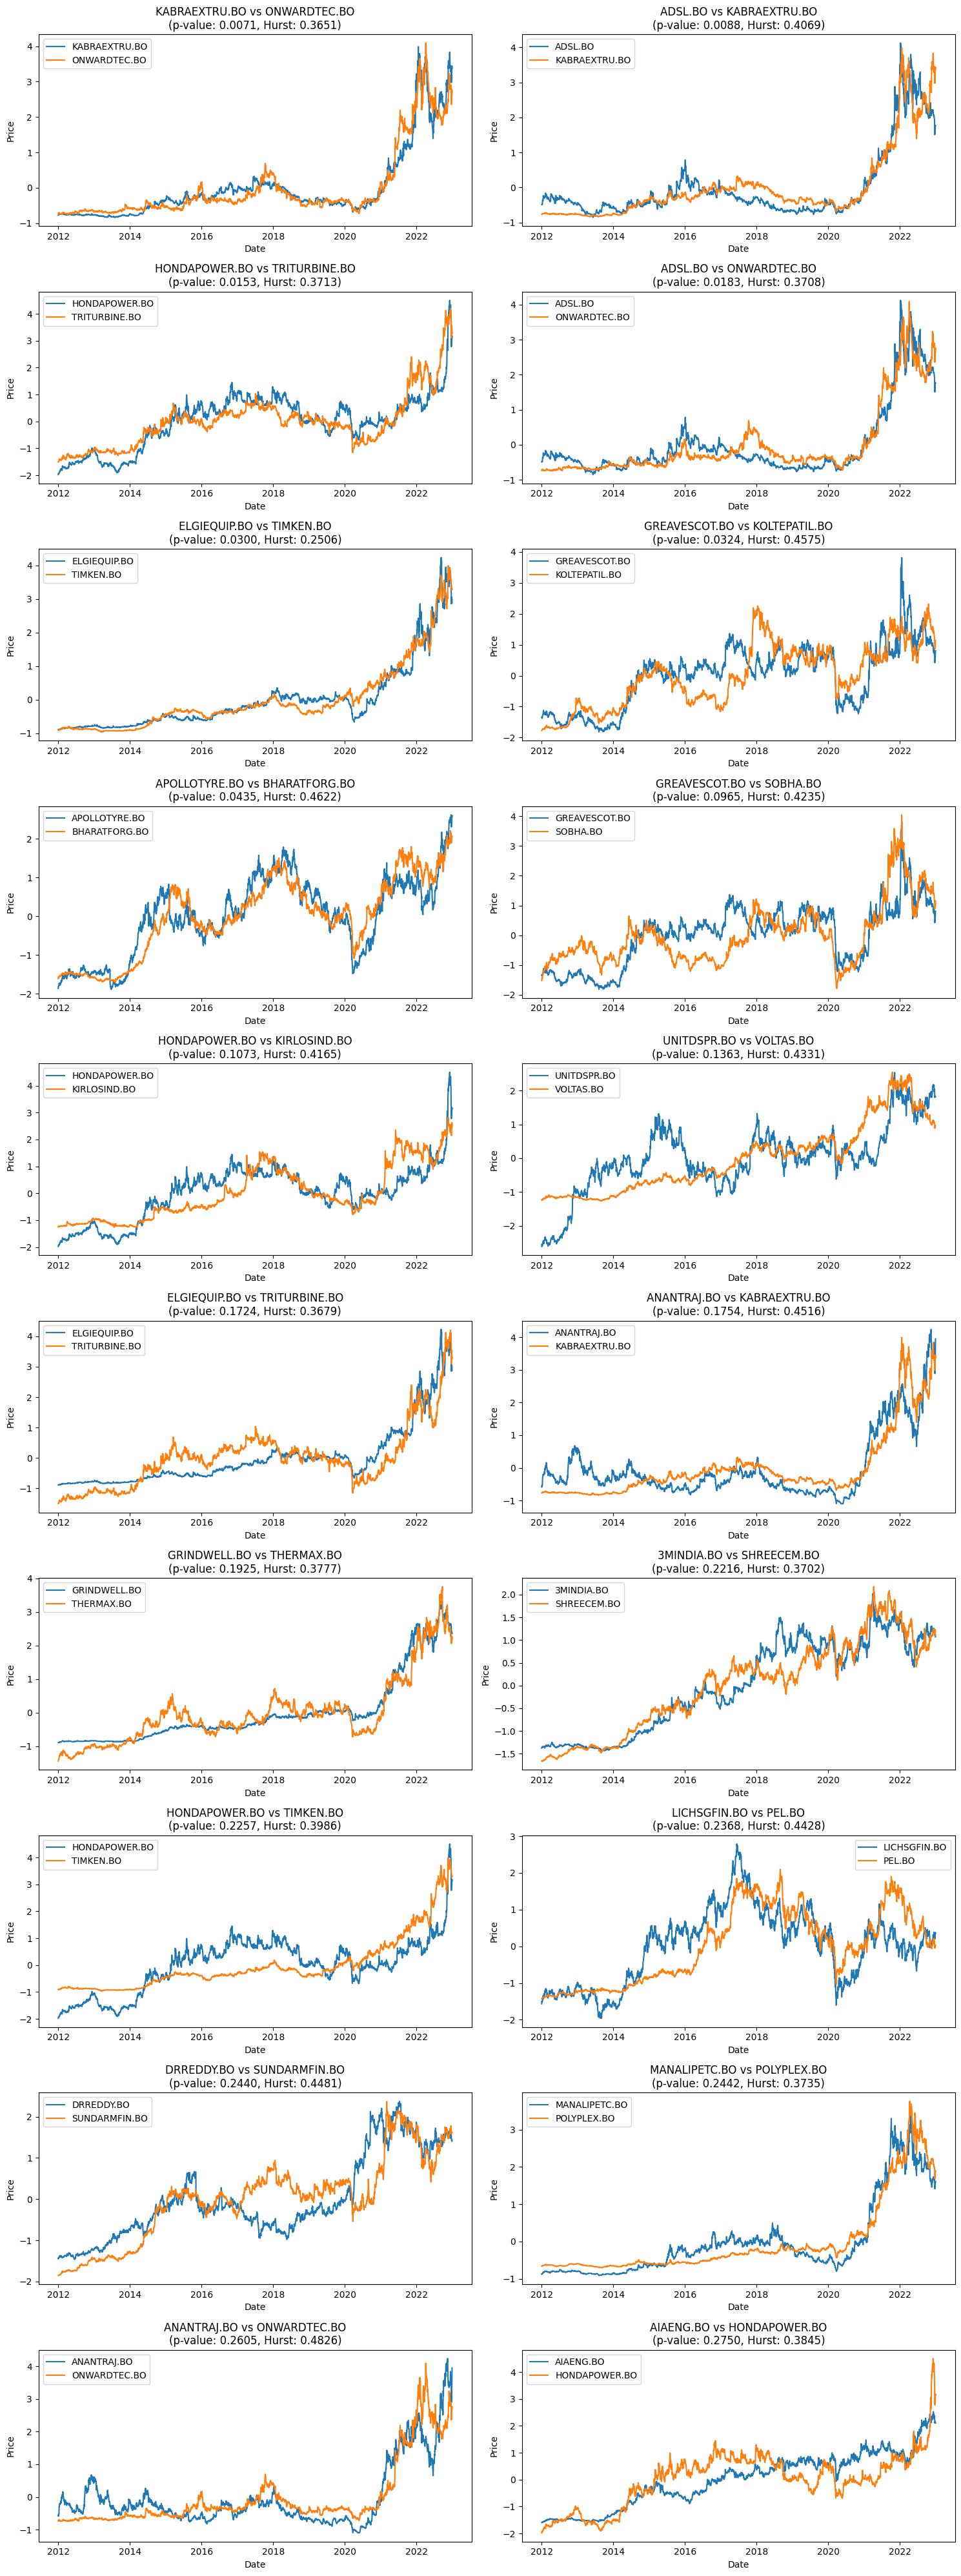

In [76]:
# --- STEP 6: Plot the time series data for each of the top 20 pairs ---
n_pairs = len(top_pairs)
nrows_plot = int(np.ceil(n_pairs / 2))
fig2, axes2 = plt.subplots(nrows=nrows_plot, ncols=2, figsize=(15, nrows_plot * 4))
axes2 = axes2.flatten()

for idx, row in enumerate(top_pairs.itertuples(index=False)):
    ticker1 = row.ticker1
    ticker2 = row.ticker2
    series1 = prices[ticker1].dropna()
    series2 = prices[ticker2].dropna()
    common_dates = series1.index.intersection(series2.index)
    if len(common_dates) == 0:
        print(f"No overlapping dates for {ticker1} and {ticker2}. Skipping plot.")
        continue
    series1_aligned = series1.loc[common_dates]
    series2_aligned = series2.loc[common_dates]

    ax = axes2[idx]
    ax.plot(series1_aligned.index, series1_aligned, label=ticker1)
    ax.plot(series2_aligned.index, series2_aligned, label=ticker2)
    ax.set_title(f"{ticker1} vs {ticker2}\n(p-value: {row.pvalue:.4f}, Hurst: {row.hurst:.4f})")
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")

plt.tight_layout()
plt.show()